In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as units
#import seaborn as sns


%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers

In [3]:
M67 = GaiaClusterMembers(295.3250, 40.19, 1)
M67.verbose = 1
M67.getData()


Retrieving Gaia data ... 
INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
M67.saveDataToFile('M67data.ecsv')

Saving data to file M67data.ecsv ... 


In [5]:
data = 'M67data.ecsv'

In [6]:
originalGaia = pd.read_csv(data, sep='\s+', skiprows=180)

In [7]:
originalGaia

,source_id,ra,dec,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_flux_over_error,...,y_mean_psf_mag_error,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error
0,2076238047602280192,294.966500,39.361183,-2.999210,-3.818512,NaN,19.883455,284.23004,20.299744,15.213822,...,0.031497,NaN,NaN,NaN,NaN,NaN,NaN,0.004710,0.071420,0.041885
1,2076248699120608640,294.752671,39.356005,-0.671946,-1.635737,NaN,20.538590,152.52092,21.097216,8.546000,...,0.108386,NaN,NaN,NaN,NaN,NaN,NaN,0.007633,0.127077,0.093990
2,2076253543843879296,294.701165,39.488968,-2.033566,-2.938065,NaN,19.750128,294.89368,19.937466,20.490114,...,0.031644,NaN,NaN,NaN,NaN,NaN,NaN,0.004599,0.053062,0.037670
3,2076266566193173888,295.252366,39.571041,-2.409607,-5.720345,NaN,16.869741,950.54517,17.254961,171.670530,...,0.004279,15.580,0.048,15.259,0.078,15.087,0.146,0.002983,0.006913,0.006297
4,2076274121030080768,295.448969,39.692846,-4.736110,-5.343965,NaN,19.319450,374.44820,19.861364,25.261162,...,0.019191,NaN,NaN,NaN,NaN,NaN,NaN,0.004000,0.043071,0.024195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255923,2073342410715449216,296.619153,40.114228,-2.470092,-7.121201,NaN,18.443281,745.86835,19.030287,41.412790,...,0.009127,NaN,NaN,NaN,NaN,NaN,NaN,0.003116,0.026365,0.010569
255924,2073342410715902208,296.618910,40.096214,-4.800062,-5.685936,NaN,17.066862,1546.42070,17.517480,203.251630,...,0.004654,15.637,0.095,15.424,0.130,14.519,NaN,0.002843,0.006027,0.005834
255925,2073342415017252608,296.615687,40.099373,-4.737668,-3.593590,NaN,20.105390,243.10023,21.297737,9.527926,...,0.014072,NaN,NaN,NaN,NaN,NaN,NaN,0.005248,0.113987,0.027227
255926,2073342415017260160,296.617120,40.099566,-0.237770,-3.299526,NaN,20.463180,152.51569,20.884764,8.850124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007633,0.122712,0.121465


In [8]:
sm = "/Users/Claire/Documents/Code/BASE9_utils/plotting/NGC6819.massSamples"
mem = "/Users/Claire/Documents/Code/BASE9_utils/plotting/NGC6819.membership"
ph = "/Users/Claire/Documents/Code/BASE9_utils/plotting/runs/NGC6819_run15_faint_mass1_PSonly_step10x/NGC6819.phot"

In [9]:
phot = pd.read_csv(ph, sep='\s+')
phot['m1Mean'] = -1
phot['m1Std'] = -1
phot['m2Mean'] = -1
phot['m2Std'] = -1
phot['qMean'] = -1
phot['qStd'] = -1
phot['memMean'] = -1
phot['memStd'] = -1
phot['member'] = False
phot['binary'] = False
phot


,id,g_ps,r_ps,i_ps,z_ps,y_ps,sigg_ps,sigr_ps,sigi_ps,sigz_ps,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
0,100300001,12.0640,11.9650,10.1610,9.0880,8.5260,0.0100,-9.9000,-9.9000,-9.900,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
1,108640002,13.2814,10.9032,9.0598,8.5864,8.8477,0.0100,0.0423,0.0100,0.010,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
2,100630010,13.3022,12.9060,12.3800,12.0310,11.8690,0.0541,-9.9000,-9.9000,-9.900,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
3,107780011,13.3640,12.7440,12.2500,11.9300,11.7740,0.0100,-9.9000,-9.9000,-9.900,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
4,100330015,13.3066,12.6870,12.2810,12.0270,11.9090,0.0126,-9.9000,-9.9000,-9.900,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,108050707,16.9935,16.5443,16.3795,16.3170,16.2767,0.0100,0.0100,0.0100,0.010,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
684,106370710,16.9967,16.5579,16.3900,16.3328,16.2853,0.0100,0.0100,0.0100,0.010,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
685,101280723,16.9122,16.4197,16.2417,16.0981,16.1181,0.0100,0.0184,0.0100,0.029,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False
686,100100886,16.7770,15.9378,16.9269,16.3198,16.5286,0.0100,0.4525,0.0627,0.010,...,-1,-1,-1,-1,-1,-1,-1,-1,False,False


In [65]:
newGaia = originalGaia[['g_mean_psf_mag', 'r_mean_psf_mag', 'z_mean_psf_mag','ra','dec']].copy()
newGaia

,g_mean_psf_mag,r_mean_psf_mag,z_mean_psf_mag,ra,dec
0,20.474199,19.904900,19.525600,294.966500,39.361183
1,21.082701,20.618900,20.247200,294.752671,39.356005
2,20.083700,19.605600,19.348499,294.701165,39.488968
3,17.342600,16.850401,16.512100,295.252366,39.571041
4,19.922701,19.325199,18.931101,295.448969,39.692846
...,...,...,...,...,...
255923,19.201300,18.456499,17.917200,296.619153,40.114228
255924,17.600599,17.070299,16.699900,296.618910,40.096214
255925,21.740101,20.578800,18.902300,296.615687,40.099373
255926,NaN,NaN,NaN,296.617120,40.099566


In [67]:
newGaia = newGaia.rename(columns={'g_mean_psf_mag': 'g_ps', 'r_mean_psf_mag': 'r_ps', 'z_mean_psf_mag': 'z_ps'})
newGaia


,g_ps,r_ps,z_ps,ra,dec
0,20.474199,19.904900,19.525600,294.966500,39.361183
1,21.082701,20.618900,20.247200,294.752671,39.356005
2,20.083700,19.605600,19.348499,294.701165,39.488968
3,17.342600,16.850401,16.512100,295.252366,39.571041
4,19.922701,19.325199,18.931101,295.448969,39.692846
...,...,...,...,...,...
255923,19.201300,18.456499,17.917200,296.619153,40.114228
255924,17.600599,17.070299,16.699900,296.618910,40.096214
255925,21.740101,20.578800,18.902300,296.615687,40.099373
255926,NaN,NaN,NaN,296.617120,40.099566


In [68]:
# should we exclude all the rows with negative sig values?
# no, we should probably include them since they are in the cluster
#
#phot = phot.loc[(phot['sigg_ps'] > 0) & (phot['sigr_ps'] > 0) & (phot['sigi_ps'] > 0) \
                # & (phot['sigz_ps'] > 0) & (phot['sigy_ps'] > 0)]
# phot

In [69]:
# get the names for the masses
massesNames = np.loadtxt(sm,max_rows = 1, dtype=str)
massesNames = np.char.replace(massesNames,'mass','')
massesNames = np.char.replace(massesNames,'ratio','')
massesNames = (massesNames[massesNames != ''])
massesNames


array(['108550067', '108550067', '109430068', ..., '100100886',
       '114852023', '114852023'], dtype='<U9')

In [70]:


# get the masses
masses = np.loadtxt(sm,skiprows=1)
print(masses.shape)
print(masses.shape[1]/2.)

(10000, 1276)
638.0


In [71]:
# get the memberships 
membership = np.loadtxt(mem)
print(membership.shape)

(10000, 638)


In [72]:
#calculate the binary fraction
nBinary = 0
nCluster = 0
count = 0
for i in range(0,masses.shape[1],2):
    # get the row in the phot file
    iden = int(massesNames[i])
    row = phot.loc[(phot['id'] == iden)]
    #print(row['id'])
    
    # get the column in the membership file
    
    imem = int((i/2))
    memArr = membership[:,imem]
    memMean = np.mean(memArr)
    memStd = np.std(memArr)
    
     #add to the phot df
    phot.at[row.index[0], 'memMean'] = memMean
    phot.at[row.index[0], 'memStd'] = memStd
    
    if (memMean - 3*memStd > 0):
        phot.at[row.index[0], 'member'] = True

        nCluster += 1
        
        # get the masses
        m1Arr = masses[:,i]
        qArr = masses[:,(i + 1)]
        m2Arr = m1Arr*qArr
        m2Mean = np.mean(m2Arr)
        m1Mean = np.mean(m1Arr)
        m2Std = np.std(m2Arr)
        qMean = np.mean(qArr)
        qStd = np.std(qArr)

        
        # add to the phot df masses (to do)
        phot.at[row.index[0], 'qMean'] = qMean
        phot.at[row.index[0], 'qStd'] = qStd
        phot.at[row.index[0], 'm1Mean'] = m1Mean
        phot.at[row.index[0], 'm2Mean'] = m2Mean
        
    
        if (m2Mean - 3*m2Std > 0):
            nBinary += 1
            phot.at[row.index[0], 'binary'] = True
            
        if (qMean>=0.5):
            count += 1
            
    #print(m1Arr)   
print(nBinary, nCluster, nBinary/nCluster, np.sqrt(nBinary)/nCluster,count,count/nCluster,np.sqrt(count)/nCluster )

146 444 0.32882882882882886 0.027214067508095883 127 0.28603603603603606 0.025381593850415864


In [73]:
phot2 = phot.loc[phot['member']]
phot2

,id,g_ps,r_ps,i_ps,z_ps,y_ps,sigg_ps,sigr_ps,sigi_ps,sigz_ps,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
51,109430068,15.0145,14.2529,13.9523,13.8039,13.7030,0.01,0.0100,0.01,0.010,...,1.440451,-1,0.425762,-1,0.295585,0.172807,0.999972,5.651057e-04,True,False
53,109950070,14.7333,14.3211,14.1706,14.1268,14.0849,0.01,0.0100,0.01,0.010,...,1.406269,-1,0.824235,-1,0.590329,0.296503,0.997787,1.334467e-02,True,False
54,105470071,14.7581,14.3148,14.1610,14.1009,14.0466,0.01,0.0100,0.01,0.010,...,1.425285,-1,0.365780,-1,0.256666,0.141098,0.999968,3.867698e-04,True,False
55,101310072,14.7924,14.3223,14.0942,14.0227,13.9737,0.01,0.0100,0.01,0.010,...,1.428313,-1,0.869995,-1,0.609106,0.016384,0.990828,3.842164e-02,True,True
56,108590073,15.0214,14.3021,14.0335,13.8801,13.7892,0.01,0.0100,0.01,0.010,...,1.439206,-1,0.911992,-1,0.633712,0.169586,0.901340,2.937029e-01,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,105760704,16.9716,16.5256,16.3581,16.3075,16.2490,0.01,0.0100,0.01,0.010,...,1.036709,-1,0.090509,-1,0.087312,0.061876,0.999999,3.719516e-05,True,False
682,112940705,16.9940,16.5121,16.3497,16.2962,16.2381,0.01,0.0100,0.01,0.010,...,1.037209,-1,0.117583,-1,0.113383,0.078254,1.000000,0.000000e+00,True,False
683,108050707,16.9935,16.5443,16.3795,16.3170,16.2767,0.01,0.0100,0.01,0.010,...,1.033330,-1,0.085854,-1,0.083090,0.058988,1.000000,1.004189e-05,True,False
684,106370710,16.9967,16.5579,16.3900,16.3328,16.2853,0.01,0.0100,0.01,0.010,...,1.031643,-1,0.081152,-1,0.078668,0.055127,0.999965,2.109010e-03,True,False


In [74]:
photBinary = phot.loc[phot['binary']]
photBinary

,id,g_ps,r_ps,i_ps,z_ps,y_ps,sigg_ps,sigr_ps,sigi_ps,sigz_ps,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
55,101310072,14.7924,14.3223,14.0942,14.0227,13.9737,0.01,0.0100,0.01,0.010,...,1.428313,-1,0.869995,-1,0.609106,0.016384,0.990828,3.842164e-02,True,True
56,108590073,15.0214,14.3021,14.0335,13.8801,13.7892,0.01,0.0100,0.01,0.010,...,1.439206,-1,0.911992,-1,0.633712,0.169586,0.901340,2.937029e-01,True,True
63,100350080,14.9551,14.5317,14.3685,14.3121,14.2636,0.01,0.0100,0.01,0.010,...,1.403924,-1,0.934298,-1,0.666506,0.101774,0.973860,1.554880e-01,True,True
64,101040081,15.1823,14.5465,14.3079,14.1860,14.0833,0.01,0.0100,0.01,0.010,...,1.433853,-1,0.752976,-1,0.525137,0.040931,0.998531,1.705929e-02,True,True
73,109760090,15.1115,14.6628,14.4950,14.4251,14.3715,0.01,0.0100,0.01,0.010,...,1.399916,-1,0.794335,-1,0.567553,0.051168,0.998369,1.786763e-02,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,111310687,16.9881,16.4822,16.2890,16.2050,16.1327,0.01,0.0100,0.01,0.010,...,1.034896,-1,0.626122,-1,0.605062,0.023459,1.000000,1.414072e-08,True,True
668,112370691,16.9571,16.4758,16.2837,16.2009,16.1475,0.01,0.0100,0.01,0.010,...,1.041976,-1,0.549419,-1,0.527335,0.032398,1.000000,1.999900e-08,True,True
670,101130693,16.9689,16.4967,16.3073,16.2306,16.1938,0.01,0.0100,0.01,0.010,...,1.041962,-1,0.366011,-1,0.351375,0.105029,1.000000,0.000000e+00,True,True
679,109640702,16.9862,16.5188,16.3355,16.2513,16.1995,0.01,0.0100,0.01,0.010,...,1.038388,-1,0.390829,-1,0.376471,0.091869,1.000000,0.000000e+00,True,True


In [75]:
newphotbinary = photBinary[['g_ps', 'r_ps','z_ps','qMean','qStd','m1Mean','m2Mean']].copy()
newphotbinary

,g_ps,r_ps,z_ps,qMean,qStd,m1Mean,m2Mean
55,14.7924,14.3223,14.0227,0.609106,0.016384,1.428313,0.869995
56,15.0214,14.3021,13.8801,0.633712,0.169586,1.439206,0.911992
63,14.9551,14.5317,14.3121,0.666506,0.101774,1.403924,0.934298
64,15.1823,14.5465,14.1860,0.525137,0.040931,1.433853,0.752976
73,15.1115,14.6628,14.4251,0.567553,0.051168,1.399916,0.794335
...,...,...,...,...,...,...,...
664,16.9881,16.4822,16.2050,0.605062,0.023459,1.034896,0.626122
668,16.9571,16.4758,16.2009,0.527335,0.032398,1.041976,0.549419
670,16.9689,16.4967,16.2306,0.351375,0.105029,1.041962,0.366011
679,16.9862,16.5188,16.2513,0.376471,0.091869,1.038388,0.390829


In [76]:
newGaia

,g_ps,r_ps,z_ps,ra,dec
0,20.474199,19.904900,19.525600,294.966500,39.361183
1,21.082701,20.618900,20.247200,294.752671,39.356005
2,20.083700,19.605600,19.348499,294.701165,39.488968
3,17.342600,16.850401,16.512100,295.252366,39.571041
4,19.922701,19.325199,18.931101,295.448969,39.692846
...,...,...,...,...,...
255923,19.201300,18.456499,17.917200,296.619153,40.114228
255924,17.600599,17.070299,16.699900,296.618910,40.096214
255925,21.740101,20.578800,18.902300,296.615687,40.099373
255926,NaN,NaN,NaN,296.617120,40.099566


In [77]:
newGaia2 = newGaia.round(4)
newGaia2

,g_ps,r_ps,z_ps,ra,dec
0,20.4742,19.9049,19.5256,294.9665,39.3612
1,21.0827,20.6189,20.2472,294.7527,39.3560
2,20.0837,19.6056,19.3485,294.7012,39.4890
3,17.3426,16.8504,16.5121,295.2524,39.5710
4,19.9227,19.3252,18.9311,295.4490,39.6928
...,...,...,...,...,...
255923,19.2013,18.4565,17.9172,296.6192,40.1142
255924,17.6006,17.0703,16.6999,296.6189,40.0962
255925,21.7401,20.5788,18.9023,296.6157,40.0994
255926,NaN,NaN,NaN,296.6171,40.0996


In [79]:
merged_Frame = pd.merge(newGaia2, newphotbinary, on=['g_ps','r_ps'])
merged_Frame_all = pd.merge(newGaia2, phot2, on=['g_ps','r_ps'])

merged_Frame_all
# why do non-binaries still have a mass ratio?

,g_ps,r_ps,z_ps_x,ra,dec,id,i_ps,z_ps_y,y_ps,sigg_ps,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
0,16.4047,15.9916,15.8062,295.1613,39.5999,121520524,15.8379,15.8062,15.7486,0.01,...,1.130187,-1,0.232872,-1,0.206117,0.119875,0.926929,0.096587,True,False
1,15.7272,15.3447,15.1397,295.2049,39.6244,120620300,15.1900,15.1397,15.0982,0.01,...,1.200700,-1,0.893956,-1,0.752904,0.182262,0.788717,0.205242,True,True
2,16.2657,15.8368,15.6072,295.4616,39.8465,115190464,15.6674,15.6072,15.5402,0.01,...,1.137224,-1,0.779603,-1,0.685772,0.037568,0.722878,0.195089,True,True
3,16.4768,16.0566,15.8586,295.4897,39.9149,113870548,15.9051,15.8586,15.8051,0.01,...,1.118274,-1,0.268565,-1,0.240245,0.124576,0.676534,0.160129,True,False
4,16.0665,15.6634,15.4864,295.4608,39.9328,113350398,15.5208,15.4864,15.4282,0.01,...,1.189326,-1,0.559447,-1,0.470558,0.085966,0.886759,0.160130,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,14.9987,14.5988,14.4184,295.2388,40.2743,107620084,14.4615,14.4184,14.3600,0.01,...,1.412716,-1,0.192035,-1,0.135974,0.094628,0.953004,0.085021,True,False
442,15.6933,15.3048,15.1266,295.2152,40.2550,107540283,15.1659,15.1266,15.0777,0.01,...,1.211068,-1,0.792102,-1,0.667778,0.271643,0.999998,0.000012,True,False
443,15.7776,15.3910,15.1991,295.2484,40.2806,107660317,15.2530,15.1991,15.1680,0.01,...,1.241780,-1,0.599048,-1,0.484507,0.144889,0.934174,0.191625,True,True
444,16.5813,16.1662,15.9801,295.2301,40.2971,108700593,16.0217,15.9801,15.9344,0.01,...,1.097755,-1,0.113467,-1,0.103374,0.072656,0.988528,0.046514,True,False


In [82]:
from astropy import units as u
for i in merged_Frame_all:
    merged_Frame_all['distance'] = np.sqrt((132.84-merged_Frame_all['ra'])**(2)+(11.81-merged_Frame_all['dec'])**2)

In [83]:

from astropy import units as u
for i in merged_Frame:
    merged_Frame['distance'] = np.sqrt((132.84-merged_Frame['ra'])**(2)+(11.81-merged_Frame['dec'])**2)
#for i in merged_Frame:
    #a=SkyCoord(ra=132.84,dec=11.81,unit='deg')
   # b=SkyCoord(ra=merged_Frame['ra'],dec=merged_Frame['dec'],unit='deg')
   # merged_Frame['distance']=a.separation(b)
    


merged_Frame




,g_ps,r_ps,z_ps_x,ra,dec,z_ps_y,qMean,qStd,m1Mean,m2Mean,distance
0,15.7272,15.3447,15.1397,295.2049,39.6244,15.1397,0.752904,0.182262,1.200700,0.893956,164.730087
1,16.2657,15.8368,15.6072,295.4616,39.8465,15.6072,0.685772,0.037568,1.137224,0.779603,165.020696
2,16.0665,15.6634,15.4864,295.4608,39.9328,15.4864,0.470558,0.085966,1.189326,0.559447,165.034592
3,16.8265,16.2980,15.9801,295.4474,40.0394,15.9801,0.878120,0.065176,1.001715,0.878005,165.039588
4,15.8679,15.4794,15.2852,295.4532,40.0591,15.2852,0.583556,0.063447,1.220784,0.711781,165.048673
...,...,...,...,...,...,...,...,...,...,...,...
141,16.6130,16.1376,15.8927,295.2909,40.2219,15.8927,0.674761,0.028083,1.084114,0.731383,164.916740
142,16.3700,15.9357,15.7279,295.3003,40.2323,15.7279,0.578844,0.035242,1.131731,0.654978,164.927791
143,16.7262,16.1996,15.9208,295.2903,40.2406,15.9208,0.845444,0.063428,1.027991,0.867638,164.919371
144,15.0214,14.3021,13.8801,295.1794,40.2521,13.8801,0.633712,0.169586,1.439206,0.911992,164.812117


Text(0.5, 0, 'Primary mass(M1)')

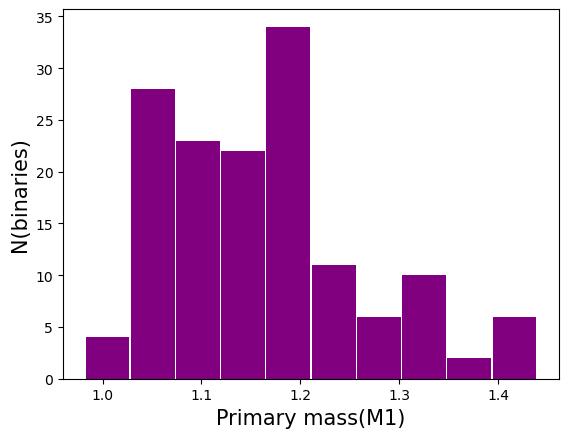

In [85]:
counts5, bins5, bars5 = plt.hist(merged_Frame['m1Mean'],bins=10, linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N(binaries)',fontsize=15)
plt.xlabel('Primary mass(M1)',fontsize=15)

Text(0.5, 0, 'Primary mass(M1)')

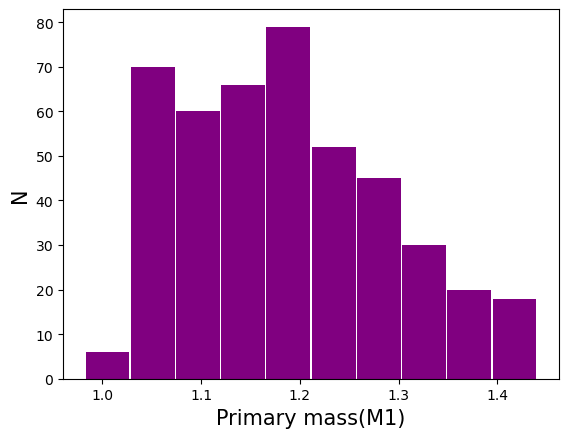

In [86]:
counts6, bins6, bars6 = plt.hist(merged_Frame_all['m1Mean'],bins=10,linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N',fontsize=15)
plt.xlabel('Primary mass(M1)',fontsize=15)

Text(0.5, 0, 'primary mass')

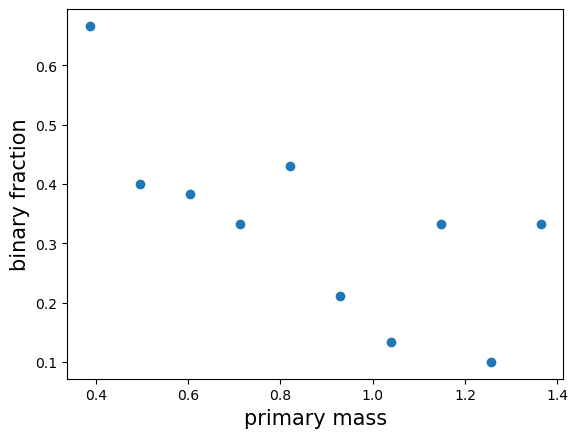

In [87]:
# the arrays arent the same size. should i be getting rid of the first bin value or last?
primarybins = [ 0.38695481, 0.49555904, 0.60416328, 0.71276751,
        0.82137175, 0.92997599, 1.03858022, 1.14718446, 1.2557887 ,
        1.36439293]
plt.scatter(primarybins,counts5/counts6)
plt.ylabel('binary fraction',fontsize=15)
plt.xlabel('primary mass',fontsize=15)

Text(0, 0.5, 'primary mass')

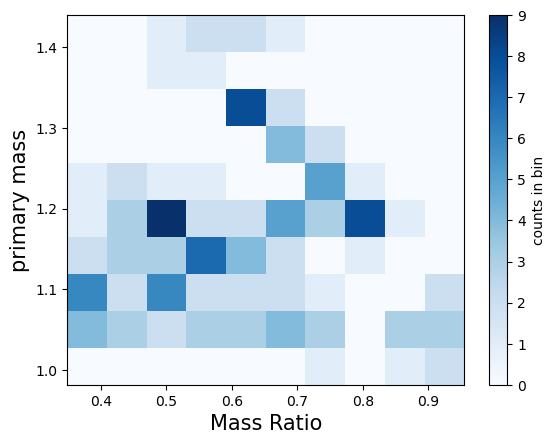

In [88]:
plt.hist2d(merged_Frame['qMean'], merged_Frame['m1Mean'], bins=10, cmap='Blues')
cb = plt.colorbar(label='counts in bin')
plt.xlabel('Mass Ratio',fontsize=15)
plt.ylabel('primary mass',fontsize=15)

Text(0, 0.5, 'distance')

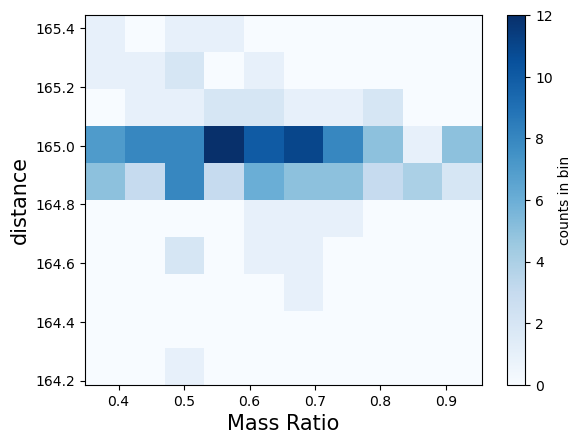

In [89]:
#qmean and distance
plt.hist2d(merged_Frame['qMean'], merged_Frame['distance'], bins=10, cmap='Blues')
cb = plt.colorbar(label='counts in bin')
plt.xlabel('Mass Ratio',fontsize=15)
plt.ylabel('distance',fontsize=15)

Text(0, 0.5, 'N (binaries)')

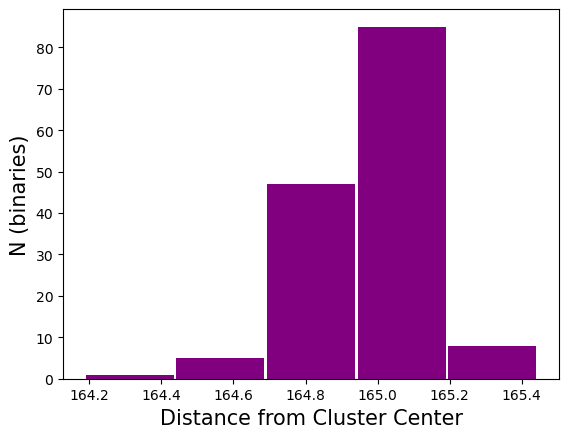

In [90]:
counts, bins, bars =plt.hist(merged_Frame['distance'], bins=5,linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=15)
plt.ylabel('N (binaries)',fontsize=15)

Text(0, 0.5, 'N')

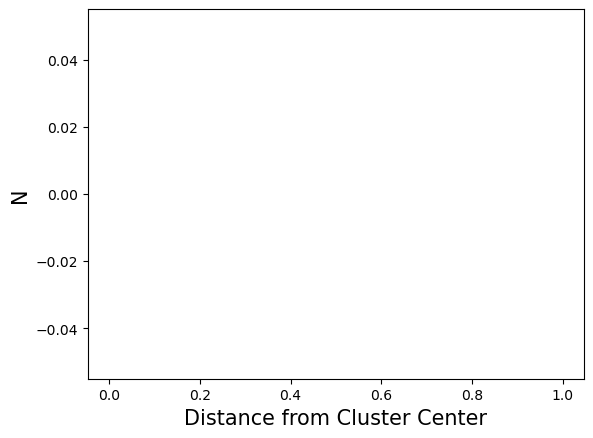

In [91]:
counts2, bins2, bars2 = plt.hist(merged_Frame_all['distance'], bins=5, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=15)
plt.ylabel('N',fontsize=15)

In [92]:
bins

array([164.18568193, 164.43748356, 164.68928519, 164.94108683,
       165.19288846, 165.44469009])

In [93]:
# is this the right way to do error? can we factor in the std of the values themselves?
errors_y = np.sqrt(counts)/counts2


/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_31226/847706480.py:2: RuntimeWarning: divide by zero encountered in divide
  errors_y = np.sqrt(counts)/counts2


/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_31226/843374667.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(bins3, counts/counts2, color='blue')


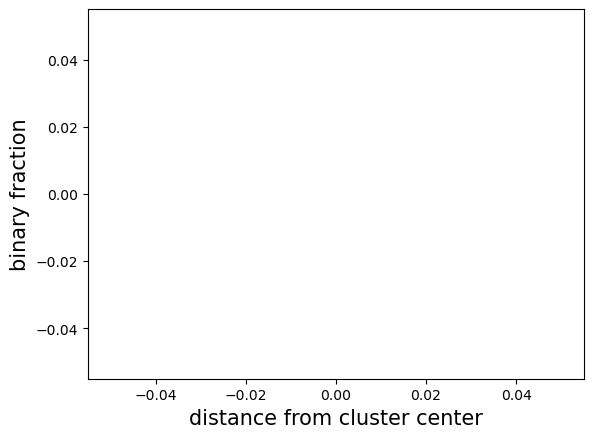

In [94]:
bins3 = [ 0.20118604, 0.3992608 , 0.59733557, 0.79541034,
       0.9934851 ]

plt.xlabel('distance from cluster center',fontsize=15)
plt.ylabel('binary fraction',fontsize=15)
plt.scatter(bins3, counts/counts2, color='blue')

/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_31226/3799132722.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(bins3, counts/counts2, xerr=None, yerr=errors_y, fmt='o',capsize=5, color='black', ecolor='red')
/Users/Claire/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3593: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/Users/Claire/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/matplotlib/axes/_base.py:2538: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


<ErrorbarContainer object of 3 artists>

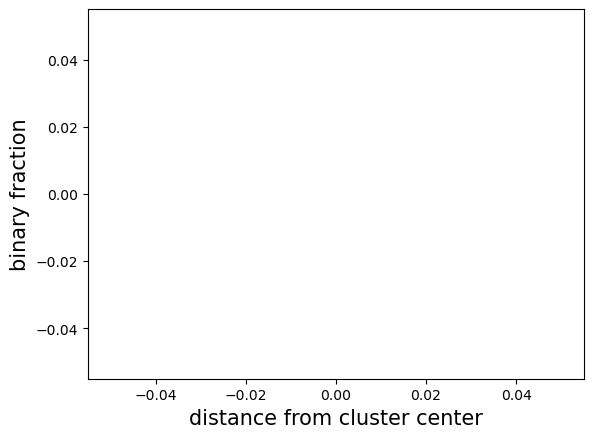

In [95]:

plt.xlabel('distance from cluster center',fontsize=15)
plt.ylabel('binary fraction',fontsize=15)
plt.errorbar(bins3, counts/counts2, xerr=None, yerr=errors_y, fmt='o',capsize=5, color='black', ecolor='red')


(23.0, 12.0)

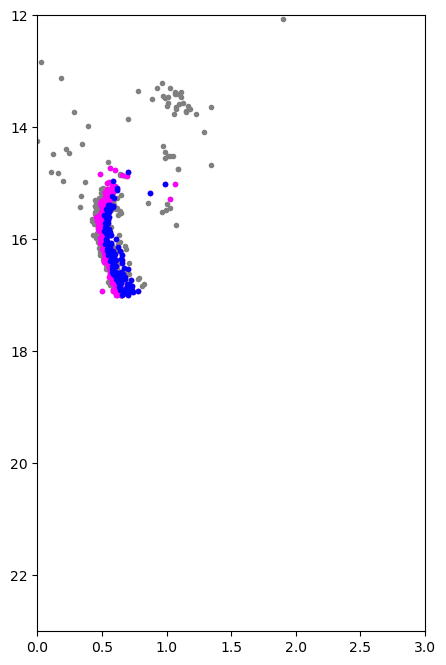

In [96]:
f, ax = plt.subplots(figsize=(5,8))
photMems = phot.loc[phot['member']]
photBinary = phot.loc[phot['binary']]
ax.plot(phot['g_ps'] - phot['i_ps'], phot['g_ps'],'.', color='gray')
ax.plot(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],'.', color='magenta')
ax.plot(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'],'.', color='blue')
ax.set_xlim(0, 3)
ax.set_ylim(23, 12)

In [22]:
photBinary

,id,G,G_BP,G_RP,g_ps,r_ps,i_ps,z_ps,y_ps,sigG,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
13,101740014,10.2229,10.7680,9.5290,99.9000,99.9000,99.9000,99.9000,99.9000,0.01,...,-1,-1,-1,-1,0.752124,0.174249,1.000000,0.000000e+00,True,True
19,100650020,10.8458,11.3872,10.1520,99.9000,99.9000,99.9000,99.9000,99.9000,0.01,...,-1,-1,-1,-1,0.815714,0.224315,1.000000,9.999500e-09,True,True
23,106450024,10.9603,11.4962,10.2709,99.9000,99.9000,99.9000,99.9000,99.9000,0.01,...,-1,-1,-1,-1,0.802066,0.224276,1.000000,0.000000e+00,True,True
33,111980034,11.6927,12.1901,11.0345,99.9000,99.9000,99.9000,99.9000,99.9000,0.01,...,-1,-1,-1,-1,0.726309,0.202539,1.000000,0.000000e+00,True,True
34,109960035,11.7849,12.2854,11.1265,99.9000,99.9000,99.9000,99.9000,99.9000,0.01,...,-1,-1,-1,-1,0.701482,0.195425,1.000000,0.000000e+00,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,110121238,19.9448,21.4755,18.7760,21.6297,20.5164,19.2231,18.6513,18.3735,0.01,...,-1,-1,-1,-1,0.309824,0.058643,1.000000,0.000000e+00,True,True
1243,104161244,20.1003,21.0225,18.8880,99.9000,20.3798,19.2679,18.7294,18.4358,0.01,...,-1,-1,-1,-1,0.612639,0.158038,0.990058,3.578776e-02,True,True
1256,112121257,20.3313,21.5010,19.2082,22.1144,20.9793,19.6063,18.9920,18.6567,0.01,...,-1,-1,-1,-1,0.391350,0.039709,1.000000,2.449163e-08,True,True
1257,109171258,20.3788,21.5304,19.0453,22.0340,21.0380,19.6081,18.9360,18.5754,0.01,...,-1,-1,-1,-1,0.857439,0.107006,0.998554,3.761933e-02,True,True


NameError: name 'M67' is not defined

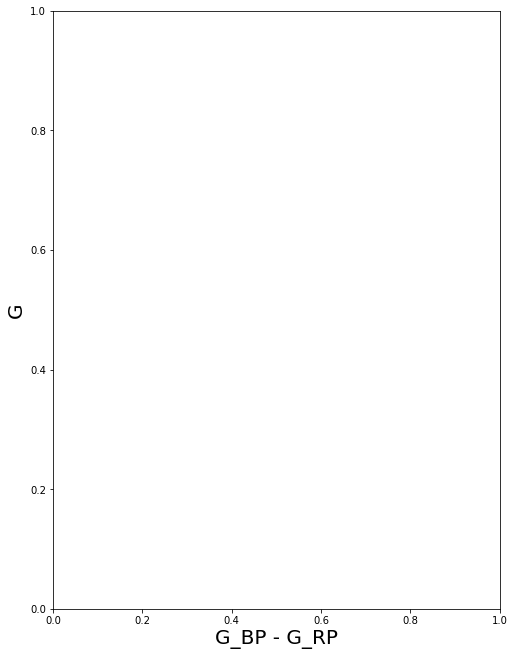

In [51]:
r = photBinary['qMean']
f, ax = plt.subplots(figsize=(8,11))

ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
#plot phot and cluster members
plt.scatter(M67.data['phot_bp_mean_mag'] - M67.data['phot_rp_mean_mag'], M67.data['phot_g_mean_mag'],s=15, color='lightgray',label='Sample From Gaia')
plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='#707070',label='Gaia Cluster Members')
plt.scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=20, color='#000000',label='Gaia+BASE9 Cluster Members')
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')
ax.set_xlim(0, 3)
ax.set_ylim(21,10)


#plot colorbar
plt.scatter(photBinary['G_BP'] - photBinary['G_RP'], photBinary['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75,label='Identified Binaries')

plt.colorbar(label="Mass Ratio", orientation="horizontal",pad=0,location='top')


#overplot isochrone
photfile = ph
cmdfile = r"C:/Users/erinm/BASE9_utils/getGaiaData/M67.ms"
mag       = 'G'
color     = 'G_BP-G_RP'.split('-')
    
    
header   = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red',linewidth=1,label='Isochrone')
plt.legend(loc="upper right",edgecolor='black')
#plt.show()
plt.savefig('MegaCMD1.png',dpi=300, bbox_inches="tight")
    
    

 

  


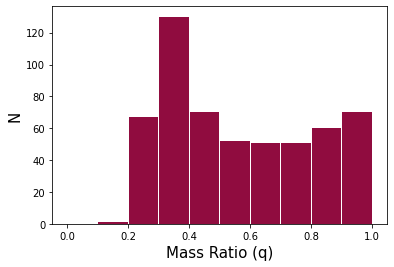

In [83]:
f, ax = plt.subplots()
photBinary = phot.loc[phot['binary']]
_ = ax.hist(photBinary['qMean'], bins=10, range=[0,1],linewidth=2,color='#900C3F',rwidth=0.97)
ax.set_xlabel('Mass Ratio (q)',fontsize=15)
ax.set_ylabel('N',fontsize=15)
plt.savefig('M67qhist1.png',dpi=300, bbox_inches="tight")

C:\Users\erinm\AppData\Local\Temp\ipykernel_18644\570507715.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('M67cmd.png', bbox='tight',dpi=300)


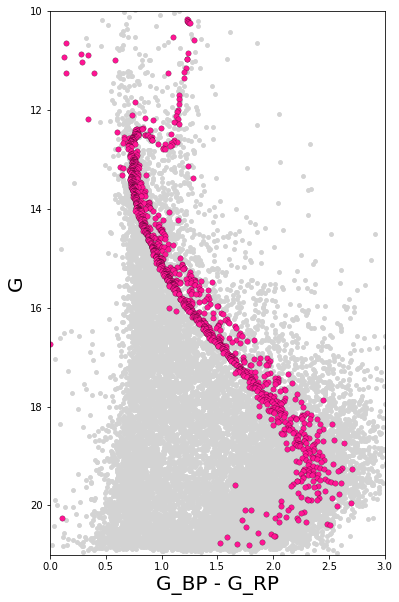

In [86]:
f, ax = plt.subplots(figsize=(6,10))

ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
#plot phot and cluster members
plt.scatter(M67.data['phot_bp_mean_mag'] - M67.data['phot_rp_mean_mag'], M67.data['phot_g_mean_mag'],s=15, color='lightgray',label='Sample From Gaia')
plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='Deeppink',label='Gaia Cluster Members', edgecolors= "black",linewidth=0.2)
ax.set_xlim(0, 3)
ax.set_ylim(21,10)
plt.savefig('M67cmd.png', bbox='tight',dpi=300)